In [1]:


import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
os.environ['HF_HOME'] = '/root/autodl-tmp/huggingface'
os.environ['MODELSCOPE_CACHE'] = '/root/autodl-tmp/modelscope/hub'

In [2]:
#!du -sh /root/autodl-tmp/deepcompressor/
# !du -sh /root/autodl-tmp/huggingface/

In [3]:
# !cp -r /root/autodl-fs/models--jasperai--Flux.1-dev-Controlnet-Depth/ /root/autodl-tmp/huggingface/hub/

In [4]:
!rm -rf ~/autodl-tmp/.Trash-0/

In [5]:

from diffusers import FluxTransformer2DModel
import torch


def load_flux_model(
    model_path: str,
    load_from_file: bool = True,
    use_4bit: bool = False,
    dtype: torch.dtype = torch.bfloat16,
) -> FluxTransformer2DModel:
    """
    加载FLUX模型，支持从单文件或预训练目录加载

    参数:
        model_path: 模型路径，可以是safetensors文件路径或预训练模型目录
        load_from_file: 是否从单个文件加载
        use_4bit: 是否使用4bit量化
        dtype: 模型计算精度
    """
    if use_4bit:
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=dtype
        )
    else:
        quantization_config = None

    if load_from_file:
        model = FluxTransformer2DModel.from_single_file(
            model_path, quantization_config=quantization_config, torch_dtype=dtype
        )
    else:
        model = FluxTransformer2DModel.from_pretrained(
            model_path, quantization_config=quantization_config, torch_dtype=dtype
        )

    return model

from huggingface_hub import hf_hub_download

ckpt_repo = "Kijai/flux-fp8"
ckpt_filename = "flux1-dev-fp8-e4m3fn.safetensors"

ckpt_path = hf_hub_download(ckpt_repo, filename=ckpt_filename)

model = load_flux_model(ckpt_path, )

In [6]:
# aa

In [7]:
from nunchaku.models.flux  import inject_transformer, load_quantized_model

qmodel_path = "mit-han-lab/svdquant-models/svdq-int4-flux.1-dev.safetensors"

if not os.path.exists(qmodel_path):
    hf_repo_id = os.path.dirname(qmodel_path)
    filename = os.path.basename(qmodel_path)
    qmodel_path = hf_hub_download(repo_id=hf_repo_id, filename=filename)


m = load_quantized_model(
        qmodel_path, "cuda"
    )

[2024-11-12 21:49:33.233] [info] Initializing QuantizedFluxModel
[2024-11-12 21:49:33.420] [info] Loading weights from /root/autodl-tmp/huggingface/hub/models--mit-han-lab--svdquant-models/snapshots/d2a46e82a378ec70e3329a2219ac4331a444a999/svdq-int4-flux.1-dev.safetensors
[2024-11-12 21:49:35.124] [info] Done.


In [8]:

import torch
from deepcompressor.app.diffusion.pipeline.t5_encoder import text_encoder_2


model = inject_transformer(model, m)


In [9]:
model = model.to("cuda")
model.device


device(type='cuda', index=0)

In [10]:
text_encoder_2.device

device(type='cuda', index=0)

In [12]:


from diffusers import FluxControlNetModel
from diffusers.pipelines import FluxControlNetPipeline
dtype = torch.bfloat16

# Load pipeline
controlnet = FluxControlNetModel.from_pretrained(
  "jasperai/Flux.1-dev-Controlnet-Depth",
  torch_dtype=torch.bfloat16
)

flux_id = "black-forest-labs/FLUX.1-dev"

pipeline = FluxControlNetPipeline.from_pretrained(
                flux_id,
                transformer=model,
                text_encoder_2=text_encoder_2,
                torch_dtype=dtype,
      controlnet=controlnet,

            )
pipeline.controlnet.to("cuda")
print(1)

pipeline.vae.to("cuda")
pipeline.text_encoder.to("cuda")

print(11)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


1
11


In [15]:
# control_image

  0%|          | 0/28 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.12/site-packages/diffusers/image_processor.py:147: RuntimeWarning: invalid value encountered in cast
  images = (images * 255).round().astype("uint8")


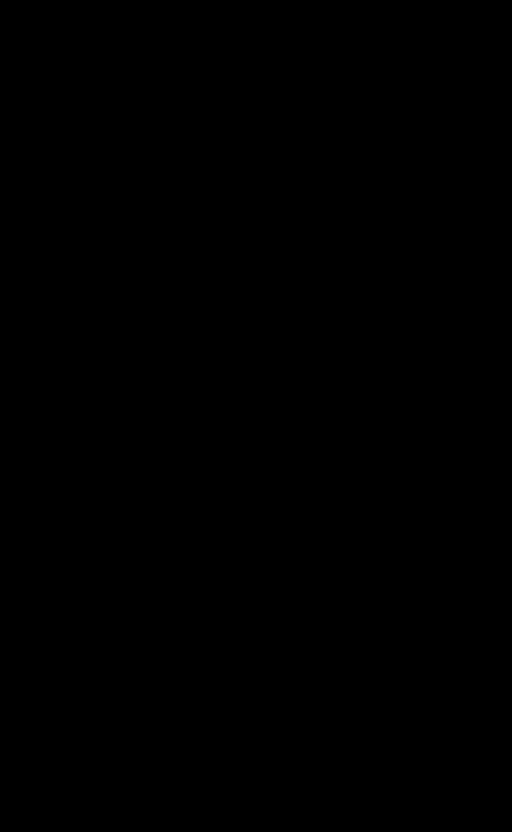

In [13]:
from diffusers.utils import load_image


control_image = load_image(
  "https://hf-mirror.com/jasperai/Flux.1-dev-Controlnet-Depth/resolve/main/examples/depth.jpg"
)



prompt = "a statue of a gnome in a field of purple tulips"

image = pipeline(
    prompt, 
    control_image=control_image,
    controlnet_conditioning_scale=0.6,
    num_inference_steps=28, 
    guidance_scale=3.5,
    height=control_image.size[1],
    width=control_image.size[0]
).images[0]
image